# Using MobileNetV3 to classify input image into 2 wheeler/4 wheeler/No Wheeler(Invalid)


In [2]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data Setup


In [4]:
# DIRECTORY INFORMATION
from pathlib import Path
from helper_functions import walk_through_dir

image_path = Path("data/vehicle_kaggle")
two_wheel_image_path_list = list(image_path.glob("1_two wheeler/*.jpg"))
four_wheel_image_path_list = list(image_path.glob("2_four wheeler/*.jpg"))
no_wheel_image_path_list = list(image_path.glob("0_no wheeler/*.jpg"))
image_path_list = list(image_path.glob("*/*.jpg"))


walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\vehicle_kaggle'.
There are 0 directories and 1000 images in 'data\vehicle_kaggle\0_no wheeler'.
There are 0 directories and 1000 images in 'data\vehicle_kaggle\1_two wheeler'.
There are 0 directories and 1000 images in 'data\vehicle_kaggle\2_four wheeler'.


### 1.1 Downloading Weights of MobileNet and checking Transformations


In [5]:
from torchvision import models

manual_transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

weights = models.MobileNet_V3_Large_Weights.DEFAULT
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

- Efficient Net V2


In [276]:
weight_effv2 = models.EfficientNet_V2_L_Weights.DEFAULT
auto_transform_effv2 = weight_effv2.transforms()
auto_transform_effv2

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


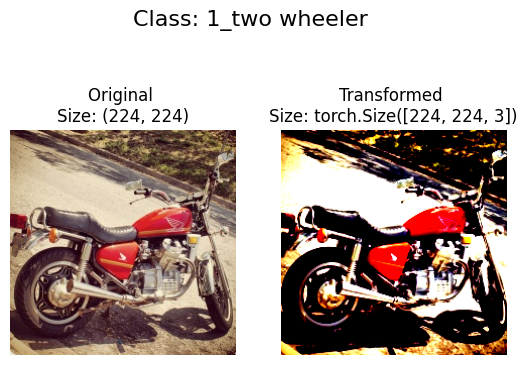

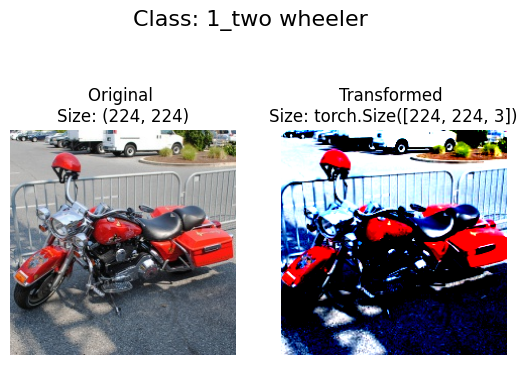

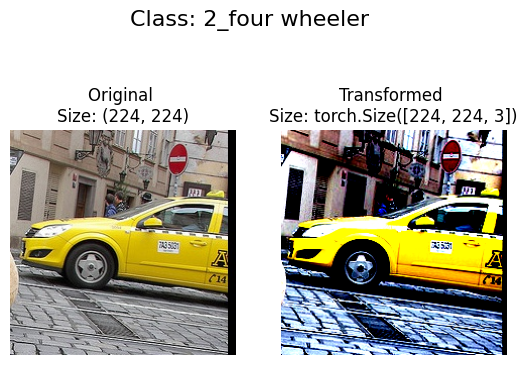

In [309]:
# VISUALIZING TRANSFORMED IMAGES
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list, auto_transform, 3, seed=5)

### 1.2 Setting up data features/labels and loaders


In [6]:
no_path = Path("data/vehicle_kaggle/0_no wheeler")
two_path = Path("data/vehicle_kaggle/1_two wheeler")
four_path = Path("data/vehicle_kaggle/2_four wheeler")

- MobileNetv3


In [7]:
data = datasets.ImageFolder(root=image_path, transform=auto_transform)
class_names = data.classes
print(f"Class dictionary: {data.class_to_idx},\nLength: {len(data)}")

Class dictionary: {'0_no wheeler': 0, '1_two wheeler': 1, '2_four wheeler': 2},
Length: 3000


- Efficientv2


In [280]:
data_effv2 = datasets.ImageFolder(root=image_path, transform=auto_transform_effv2)

### 1.3 SPLITTING THE DATA ARRAY INDICES INTO TRAIN AND TEST

- 0-999 "No Wheelers", so taking 0-800 in train and 800-1000 in test
- 1000-1800 "Two Wheeler", same as above
- 2000-2800 "Four Wheeler", same as above


In [8]:
train_indices = (
    [i for i in range(0, 800)]
    + [i for i in range(1000, 1800)]
    + [i for i in range(2000, 2800)]
)
test_indices = (
    [i for i in range(800, 1000)]
    + [i for i in range(1800, 2000)]
    + [i for i in range(2800, 3000)]
)

In [9]:
from torch.utils.data import Subset

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)
len(train_data), len(test_data)

(2400, 600)

In [10]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed(42)
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1d786315c70>,
 <torch.utils.data.dataloader.DataLoader at 0x1d791536de0>)

- EfficientV2


In [281]:
from torch.utils.data import Subset

train_data_effv2 = Subset(data_effv2, train_indices)
test_data_effv2 = Subset(data_effv2, test_indices)
len(train_data), len(test_data)

(2400, 600)

In [12]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed(42)
BATCH_SIZE = 32

train_loader_effv2 = DataLoader(
    train_data_effv2,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader_effv2 = DataLoader(
    test_data_effv2,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
train_loader_effv2, test_loader_effv2

(<torch.utils.data.dataloader.DataLoader at 0x1d791529730>,
 <torch.utils.data.dataloader.DataLoader at 0x1d78ab7e330>)

### 1.4 Visualizing random images from the data loader


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label: 0_no wheeler


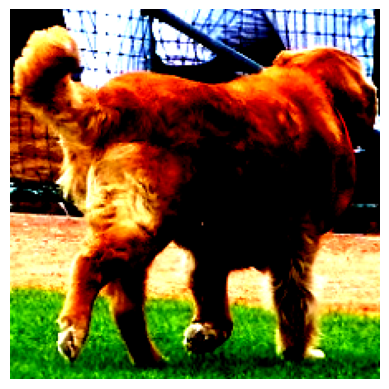

In [14]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {class_names[label]}")
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.show()

## 2. Instantiating Model from torchvision.models


- MobileNetV3


In [15]:
from torchvision import models


weightsv3 = models.MobileNet_V3_Large_Weights.DEFAULT
modelv3 = models.mobilenet_v3_large(weights=weightsv3).to(device)

- EfficientV2


In [404]:
from torchvision import models

weights_effv2 = models.EfficientNet_V2_L_Weights.DEFAULT
efficientv2 = models.efficientnet_v2_l(weights=weights_effv2).to(device)

### 2.1 Info for model


In [22]:
from torchinfo import summary

summary(
    modelv3,
    input_size=(32, 3, 480, 480),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 480, 480]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 480, 480]    [32, 960, 15, 15]    --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 480, 480]    [32, 16, 240, 240]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 480, 480]    [32, 16, 240, 240]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 240, 240]   [32, 16, 240, 240]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 240, 240]   [32, 16, 240, 240]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 240, 240]   [32, 

### 2.2 Freezing layers and re-defining the last layer


- MobileNetV3


In [17]:
for param in modelv3.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
modelv3.classifier = nn.Sequential(
    nn.Linear(
        in_features=960,
        out_features=1280,
        bias=True,
    ),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)

#      Modelv3 Classifier Layer
#     (0)Linear(in_features=960, out_features=1280, bias=True)
#     (1): Hardswish()
#     (2): Dropout(p=0.2, inplace=True)
#     (3): Linear(in_features=1280, out_features=1000, bias=True)

- efficientv2


In [405]:
for param in efficientv2.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
efficientv2.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True,
    ),
).to(device)

# Efficient net classifier
# Sequential(
#     (0): Dropout(p=0.4, inplace=True)
#     (1): Linear(in_features=1280, out_features=1000, bias=True)

## 3.Training Time


- MobileNet v3


In [25]:
loss_fn_large = nn.CrossEntropyLoss()
optimizer_large = torch.optim.AdamW(modelv3.parameters(), amsgrad=True)
# optimizer_large = torch.optim.AdamW(modelv3.parameters())
# optimizer_large = torch.optim.SGD(modelv3.parameters(), lr=0.005, momentum=0.9)

In [26]:
import engine  # contains our training functions

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results_v3large = engine.train(
    model=modelv3,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer_large,
    loss_fn=loss_fn_large,
    epochs=5,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2705 | train_acc: 0.8988 | test_loss: 0.2609 | test_acc: 0.9128
Epoch: 2 | train_loss: 0.1379 | train_acc: 0.9517 | test_loss: 0.3103 | test_acc: 0.8991
Epoch: 3 | train_loss: 0.1235 | train_acc: 0.9550 | test_loss: 0.3102 | test_acc: 0.9112
Epoch: 4 | train_loss: 0.0823 | train_acc: 0.9704 | test_loss: 0.3661 | test_acc: 0.8909
Epoch: 5 | train_loss: 0.0963 | train_acc: 0.9658 | test_loss: 0.3679 | test_acc: 0.9084
[INFO] Total training time: 103.525 seconds


In [397]:
from utils import save_model

save_model(modelv3, "data/saved_models", "")

[INFO] Saving model to: data\saved_models\effv2_codan_AdamW.pth


In [21]:
modelv3.load_state_dict(torch.load("data/saved_models/modelv3_codan_adam.pth"))

<All keys matched successfully>

- efficientv2


In [406]:
loss_fn_effv2 = nn.CrossEntropyLoss()
optimizer_effv2 = torch.optim.RMSprop(efficientv2.parameters())

In [413]:
import engine  # contains our training functions

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results_effv2 = engine.train(
    model=efficientv2,
    train_dataloader=train_loader_effv2,
    test_dataloader=test_loader_effv2,
    optimizer=optimizer_effv2,
    loss_fn=loss_fn_effv2,
    epochs=3,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2516 | train_acc: 0.9492 | test_loss: 0.7533 | test_acc: 0.9254
Epoch: 2 | train_loss: 0.2659 | train_acc: 0.9487 | test_loss: 0.7370 | test_acc: 0.9309
Epoch: 3 | train_loss: 0.2822 | train_acc: 0.9475 | test_loss: 0.9710 | test_acc: 0.9128
[INFO] Total training time: 350.496 seconds


# 4. Visualizing the Results


In [27]:
results = {}

In [29]:
results.update(results_v3large)

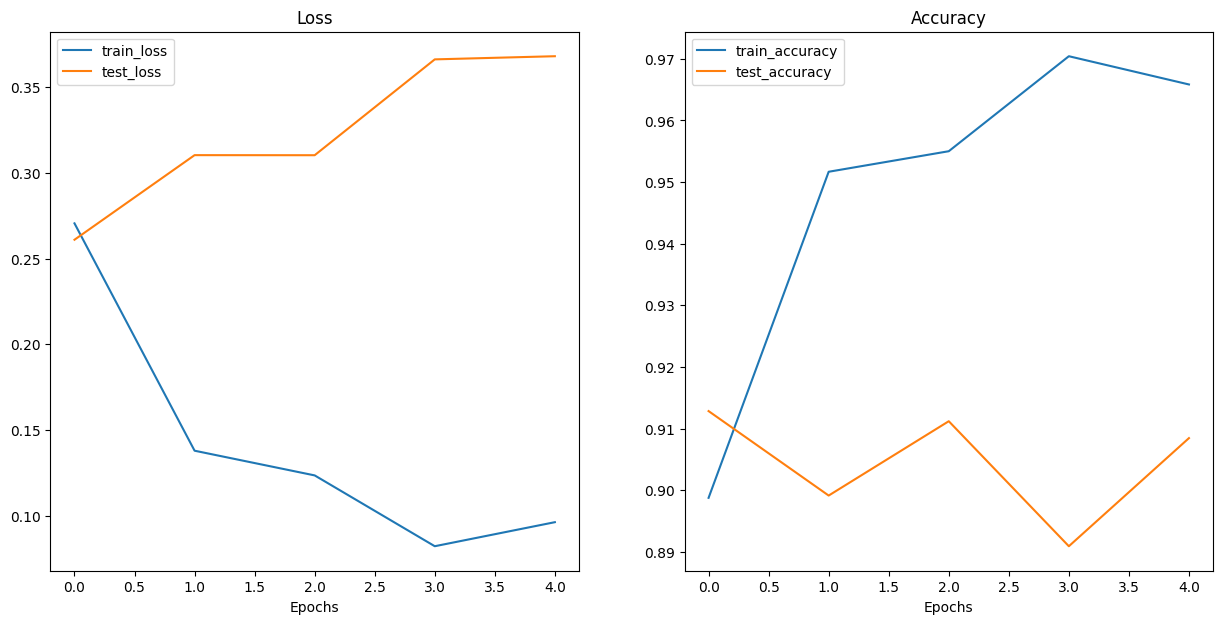

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [32]:
# Loading unseen data from directory
new_dir = "data/unseen"
unseen_dataset = datasets.ImageFolder(new_dir, transform=auto_transform)
unseen_loader = DataLoader(
    unseen_dataset,
    shuffle=False,
)

# Get samples and labels from the unseen data in different lists
test_samples = []
test_labels = []
for sample, label in unseen_loader:
    test_samples.append(sample)
    test_labels.append(label.item())

In [33]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)  # Add an extra dimension for batch

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # Perform softmax on the channel dimension

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.cat(pred_probs, dim=0)


pred_probs = make_predictions(model=modelv3, data=test_samples)
# Converting prediction probabilities into labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

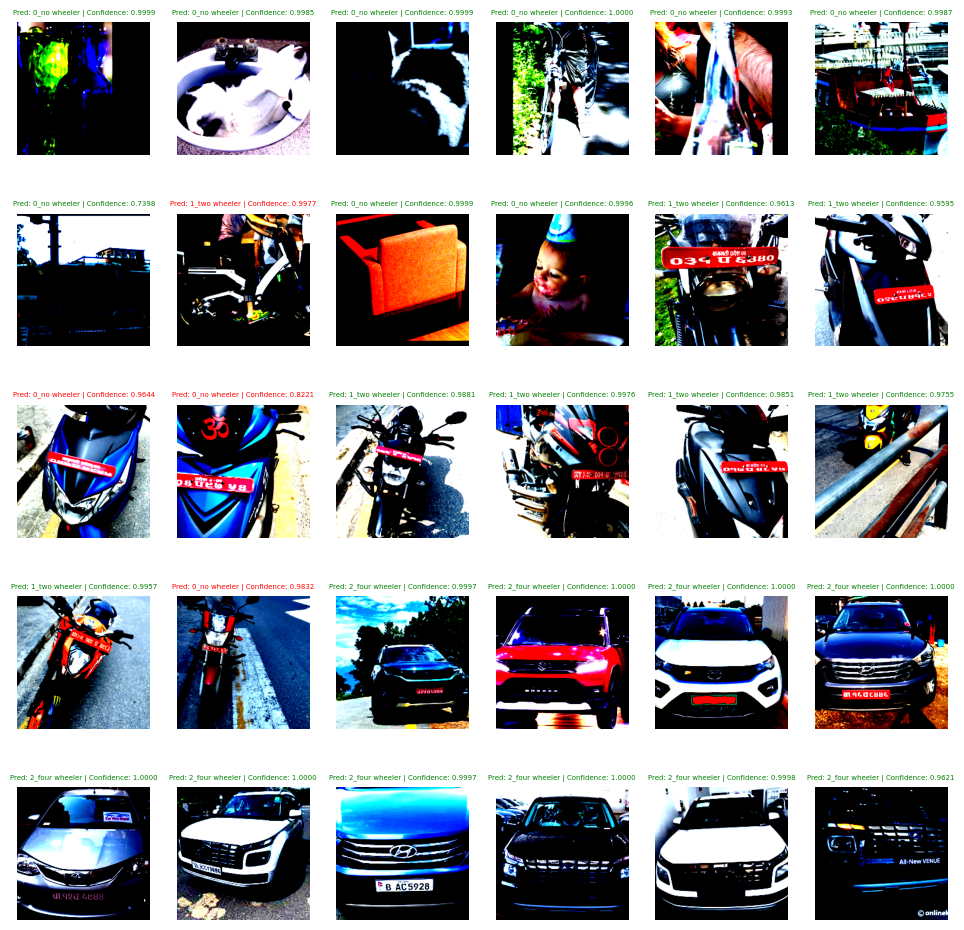

In [34]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 5
ncols = 6
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    sample = sample.squeeze()
    plt.title("SCORE: {accuracy}%")
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_labels[i].item()]
    truth_label = class_names[test_labels[i]]

    # Get the confidence score for the prediction from pred_probs
    confidence = torch.max(pred_probs[i]).item()

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Confidence: {confidence:.4f}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=5, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=5, c="r")  # red text if wrong
    plt.axis(False)

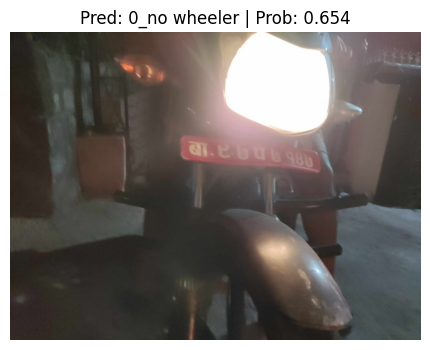

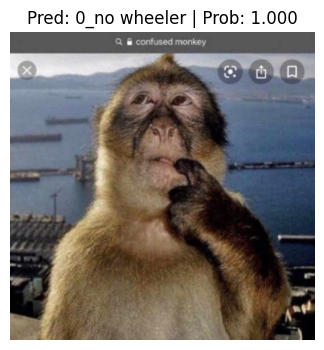

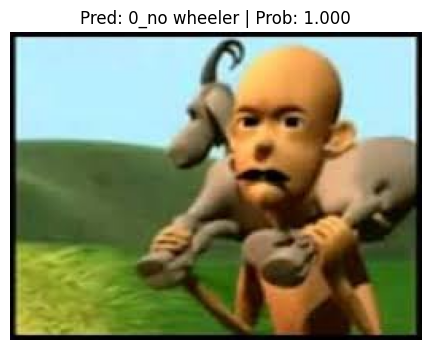

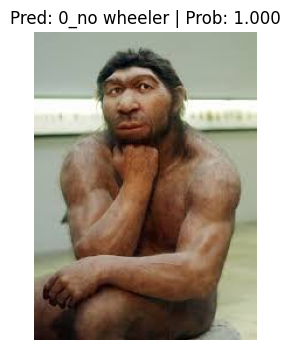

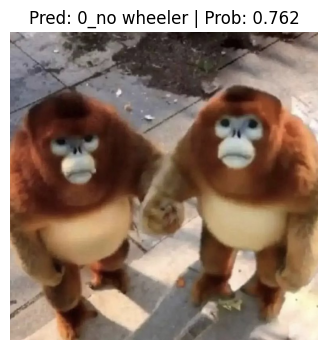

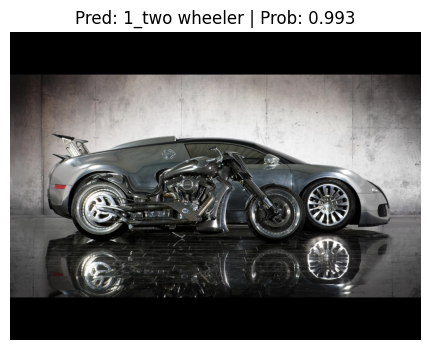

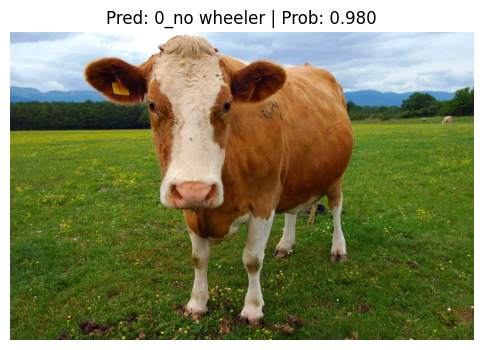

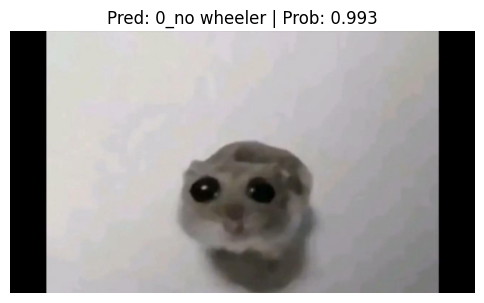

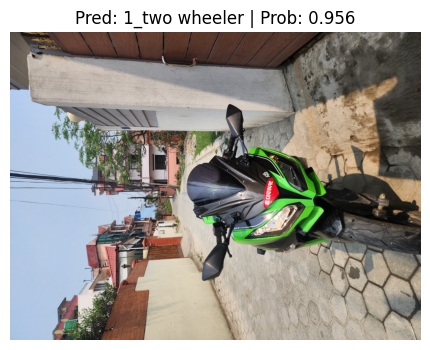

In [35]:
from pathlib import Path
from predictions import pred_and_plot_image


test_dir = "data/custom"


dir_path = list(Path(test_dir).glob("*.jpg"))


for image in dir_path:

    pred_and_plot_image(
        image_path=image,
        model=modelv3,
        class_names=class_names,
        device=device,
        image_size=(224, 224),
        transform=auto_transform,
    )